### Parte 2: Análise Exploratória de Dados e Processamento da Linguagem Natural

### Problema de negócio:
Lore ipsu sit

In [1]:
import re

import string

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency


import pandas as pd
from io import StringIO

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Processamento de Linguagem Natural
import spacy
from spacy.symbols import amod
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.probability import FreqDist

# Topic Modeling
import sklearn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

#importando as libraries necessárias para o wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

import warnings

# Desativar todos os warnings
warnings.filterwarnings("ignore")

C:\Users\pedro\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Importando configurações, paths e funções

from config import processed_path
from utils import differences_test_cat, differences_test_num, normality_test, predict_sentiment, textblob_sentiment_polarity, textblob_classify_polarity, textblob_subjectivity, bar_plot, boxplot_plot, simple_bar_plot

In [3]:
# Baixando o modelo pré-treinado de língua portuguesa do spaCy

!python -m spacy download pt 

⚠ As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the
full pipeline package name 'pt_core_news_sm' instead.
     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
     --------------------------------------- 0.0/13.0 MB 110.1 kB/s eta 0:01:58
     --------------------------------------- 0.0/13.0 MB 178.6 kB/s eta 0:01:13
     --------------------------------------- 0.1/13.0 MB 201.8 kB/s eta 0:01:05
     --------------------------------------- 0.1/13.0 MB 291.5 kB/s eta 0:00:45
      -------------------------------------- 0.3/13.0 MB 780.5 kB/s eta 0:00:17
     -- ------------------------------------- 0.7/13.0 MB 1.9 MB/s eta 0:00:07
     -- ------------------------------------- 0.9/13.0 MB 2.1 MB/s eta 0:00:06
     ---- ----------------------------------- 1.4/13.0 MB 3.1 MB/s eta 0:00:04
     ------- ---------

In [3]:
# importando o modelo de linguagem pré-treinado
import pt_core_news_sm

# instanciando o modelo pré-treinado
nlp = pt_core_news_sm.load()

___________________________________________________________________

#### 2.1 Leitura do arquivo de dados processado

In [4]:
# Ingestão do arquivo processado

df = pd.read_parquet(processed_path)

In [5]:
# Síntese analítica dos dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Idade                        101 non-null    int64         
 1   Gênero                       101 non-null    object        
 2   Estado Civil                 101 non-null    object        
 3   Número de Dependentes        101 non-null    int64         
 4   Data de Início do Contrato   101 non-null    datetime64[ns]
 5   Data de Término do Contrato  4 non-null      datetime64[ns]
 6   Valor Mensal do Contrato     101 non-null    float64       
 7   Tipo de Serviço              101 non-null    object        
 8   Duração Média das Chamadas   61 non-null     float64       
 9   Volume de Dados              13 non-null     float64       
 10  Número de Reclamações        53 non-null     float64       
 11  Comentários                  101 non-null    

In [6]:
# Visualização dos dados do dataframe

df.head(3)

,Idade,Gênero,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários,churn,cidade,estado_sigla,duracao_contrato,comentarios_eng
0,35,Masculino,Casado,2,2018-05-10,NaT,79.99,Telefonia Móvel,4.5,2.3,2.0,O serviço de internet tem sido instável. Estou...,0,São Paulo,SP,NaN,Internet service has been unstable. I'm having...
1,28,Feminino,Solteiro,0,2019-03-15,NaT,109.99,Internet,NaN,NaN,0.0,Estou satisfeita com o serviço. A velocidade d...,0,Rio de Janeiro,RJ,NaN,I am satisfied with the service. The internet ...
2,42,Masculino,Casado,1,2020-01-20,2021-06-30,139.99,Internet,NaN,NaN,1.0,Tive problemas com a fatura deste mês. O valor...,1,Belo Horizonte,MG,527.0,I had problems with this month's invoice. The ...


_____________________________________________________

#### 2.2 Análise da Linguagem Natural nos comentários

Utilizando a framework Flair para obter os seguintes dados:
 - flair_sentiment_analysis : Avaliação do sentimento do usuário do redigir o comentário. O framework o classifica como NEGATIVE ou POSITIVE
 - flair_sentiment_score : O grau de confiança na decisão.

Importante: O framework Flair não é capaz de analisar textos na língua portuguesa, por isso utilzou-se os comentários traduzidos para inglês.

In [7]:
# Obtendo a classificação de sentimentos com Flair

df[['flair_sentiment_analysis', 'flair_sentiment_score']] = df['comentarios_eng'].apply(predict_sentiment).apply(pd.Series)

Também foi usada a framework textblob para a análise de sentimentos, de modo que também pudessem ser obtidos valores de polaridade para os sentimentos, sendo eles: 

textblob
 - 0: Neutro
 - -1: Negativo
 - 1: Positivo

Flair
 - 0: Negativo
 - 1: Positivo

A avaliação utilizando-se de dois frameworks faz-se necessária para efeito de comparação, inclusive indicando inconsistências, caso as análises sejam incongruentes.

In [8]:
# Obtendo a análise de sentimentos com textblob

df['textblob_sentiment_polarity'] = df['comentarios_eng'].apply(textblob_sentiment_polarity)

df['textblob_sentiment_analysis'] = df['textblob_sentiment_polarity'].apply(textblob_classify_polarity)

df['textblob_subjectivity'] = df['comentarios_eng'].apply(textblob_subjectivity)


In [9]:
# Visualizando o resultado das análises

df[['flair_sentiment_analysis', 'flair_sentiment_score','textblob_sentiment_polarity','textblob_sentiment_analysis']]

,flair_sentiment_analysis,flair_sentiment_score,textblob_sentiment_polarity,textblob_sentiment_analysis
0,NEGATIVE,0.999990,-0.163333,NEGATIVE
1,POSITIVE,0.989836,0.433333,POSITIVE
2,NEGATIVE,0.999945,0.000000,NEUTRAL
3,POSITIVE,0.985523,0.300000,POSITIVE
4,NEGATIVE,0.999992,-0.100000,NEGATIVE
...,...,...,...,...
96,NEGATIVE,0.999995,-0.450000,NEGATIVE
97,NEGATIVE,0.999996,-0.075000,NEGATIVE
98,NEGATIVE,0.999995,-0.140000,NEGATIVE
99,NEGATIVE,0.999993,-0.175000,NEGATIVE


O código abaixo foi utilizado para verificar a similaridade entre os sentimentos obtidos por meio do Flair do do textblob

In [10]:
contador = 0

def verificar_e_incrementar(row):
    global contador
    if row['textblob_sentiment_analysis'] == row['flair_sentiment_analysis']:
        contador += 1
    return row

df = df.apply(verificar_e_incrementar, axis=1)

print(f'Contador: {contador}')

Contador: 87


Comparação entre os resultaados do textblob e Flair

In [11]:
flair_counts = df['flair_sentiment_analysis'].value_counts().to_dict()

textblob_counts = df['textblob_sentiment_analysis'].value_counts().to_dict()

df_flair_counts = pd.DataFrame(list(flair_counts.items()), columns=['Sentimento', 'Contagem_flair'])
df_textblob_counts = pd.DataFrame(list(textblob_counts.items()), columns=['Sentimento', 'Contagem_textblob'])

df_counts = pd.merge(df_flair_counts, df_textblob_counts, on='Sentimento', how='outer')

df_counts = df_counts.fillna(0)

df_counts

,Sentimento,Contagem_flair,Contagem_textblob
0,POSITIVE,53.0,64
1,NEGATIVE,48.0,34
2,NEUTRAL,0.0,3


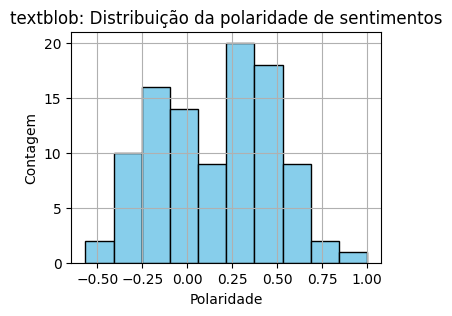

In [12]:
# Gráfico da distribuição da polaridade de sentimentos do textblob

plt.figure(figsize=(4, 3))

df['textblob_sentiment_polarity'].hist(bins=10, color='skyblue', edgecolor='black')

plt.title('textblob: Distribuição da polaridade de sentimentos')
plt.xlabel('Polaridade')
plt.ylabel('Contagem')

plt.show()

A <b>distribuição de polaridades</b> indica que os clientes fazem comentários com maior volumetria positiva. Além disso, a maior distribuição ocorre entre os polos -0.25 e 0.75, com uma bicaudalidade (0.25-0;0.25-0.5 ) com maior volumetria para a cauda positiva, mostrando que a opinião geral dos clientes tende a ser positiva, além da indicação que os comentários possuem organicidade (podem não ter sido gerados por ferramentas).

A <b>análise de subjetividade</b> foi utilizada para avaliar o quanto da opinião percebida nos comentários é personalíssima e quanto dela são pontos generalizados, considerados lugares-comum nas expressões textuais. Reflete especialmente o quanto de particularidade existe nos comentários.

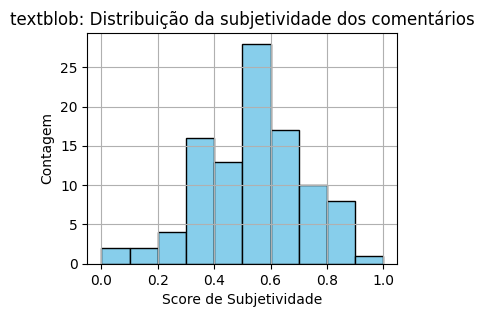

In [13]:
# Gráfico da distribuição da subjetividade dos comentários com textblob

plt.figure(figsize=(4, 3))

df['textblob_subjectivity'].hist(bins=10, color='skyblue', edgecolor='black')

plt.title('textblob: Distribuição da subjetividade dos comentários')
plt.xlabel('Score de Subjetividade')
plt.ylabel('Contagem')

plt.show()

Aqui, percebe-se que a a subjetividade concentra-se especialmente entre os scores 0.2 e 0.8, com maior distribuição volumétrica entre 0.4 e 0.6 o que é um comportamente esperado em comentários opinativos, o que além de indicar que os <b>comentários indicam possuir organicidade</b>, podendo ser considerados autênticos (não gerados por ferramenta de síntese de texto automática).

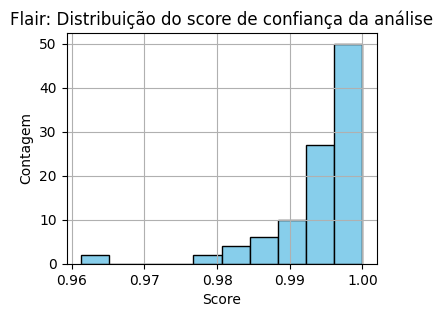

In [14]:
# Gráfico da distribuição dos scores de seguranca do Flair

plt.figure(figsize=(4, 3))

df['flair_sentiment_score'].hist(bins=10, color='skyblue', edgecolor='black')

plt.title('Flair: Distribuição do score de confiança da análise')
plt.xlabel('Score')
plt.ylabel('Contagem')

plt.show()

O framework <b>Flair apresentou um grau de confiabilidade na classificação entre 0.96 e 0.99</b>, o que o coloca em uma faixa de confiabilidade importante. O framework textblob não mostra a confiabilidade das decisões, o que posiciona o Flair como um framework melhor para as tomadas de decisão subsequentes.

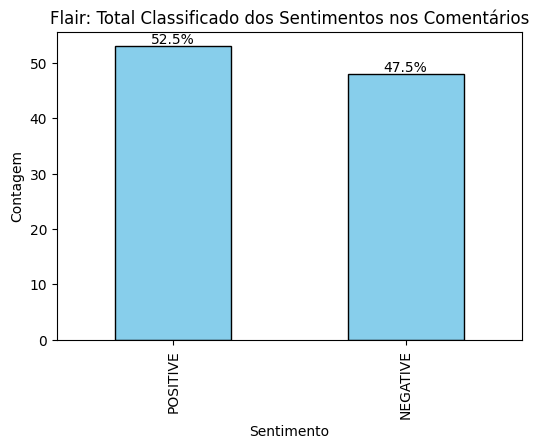

In [15]:
plt.figure(figsize=(6, 4))

count_values = df['flair_sentiment_analysis'].value_counts()

ax = count_values.plot(kind='bar', color='skyblue', edgecolor='black')

total = count_values.sum()
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.1%}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Flair: Total Classificado dos Sentimentos nos Comentários')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')

plt.show()

Os comentários são, em sua maioria, POSITIVOS em relação à empresa e seus diversos serviços prestados

Para efeito diagnóstico, é necessário determinar quais serviços tem mais ou menos comentários positivos.

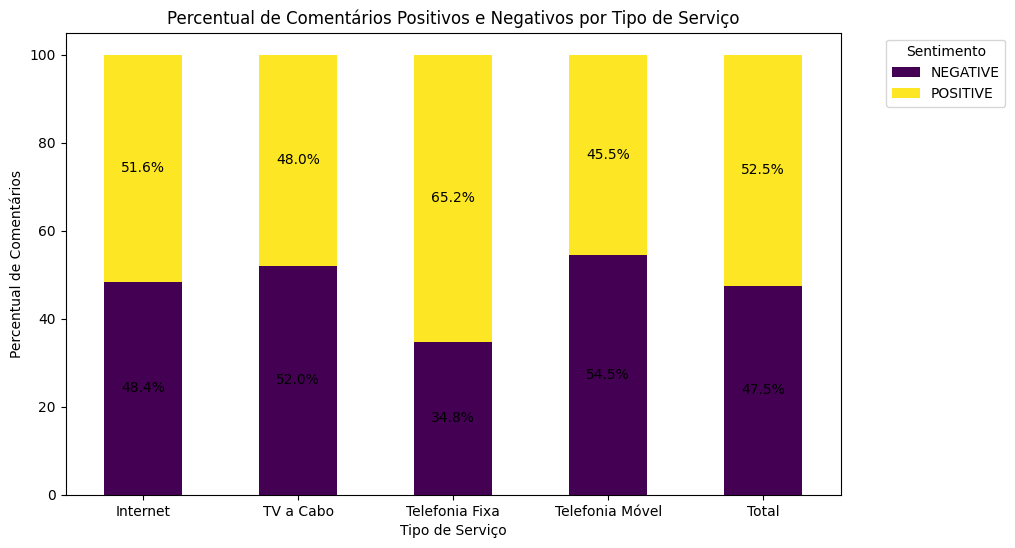

In [16]:
# Grafico de percentual de sentimentos por Tipo de Serviço

bar_plot('flair_sentiment_analysis', 'Tipo de Serviço', df)

O serviço de Telefonia Fixa é o que melhor performou nos comentários. A Telefonia Móvel, no entando, apresentou uma performance menor. Os demais serviços possuem variações mais equilibradas entre comentários positivos e negativosd.

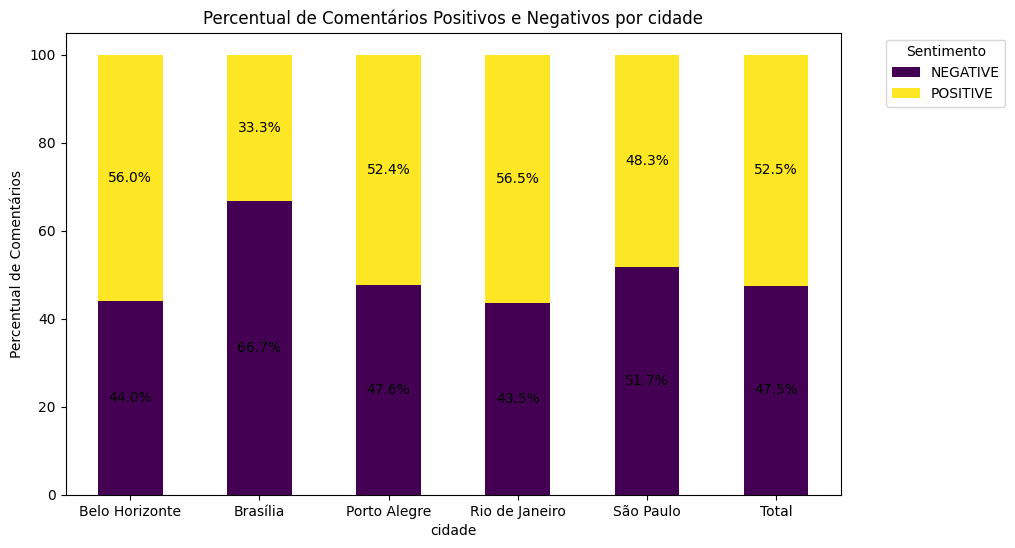

In [17]:
# Grafico de percentual de sentimentos por cidade

bar_plot('flair_sentiment_analysis', 'cidade', df)

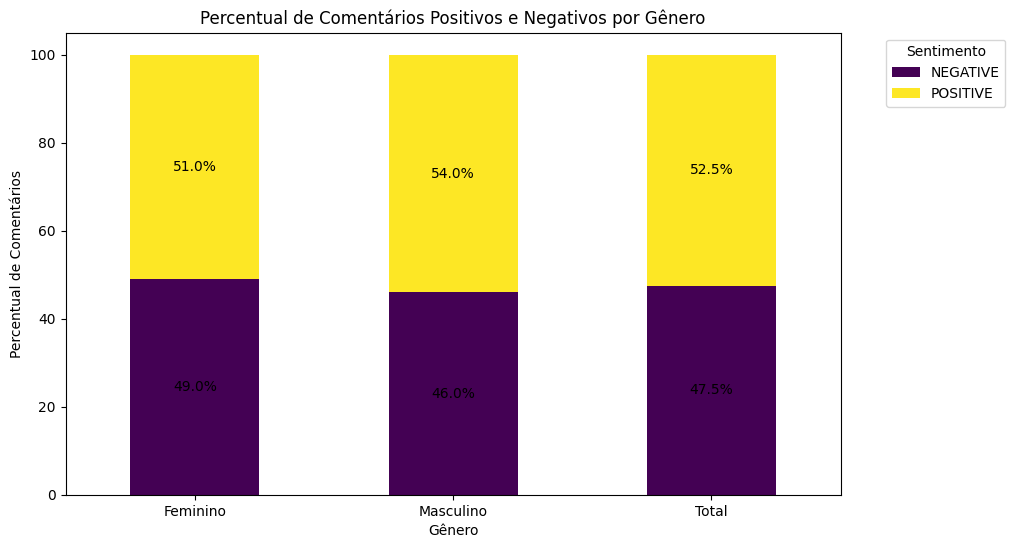

In [18]:
# Grafico de percentual de sentimentos por sexo

bar_plot('flair_sentiment_analysis', 'Gênero', df)

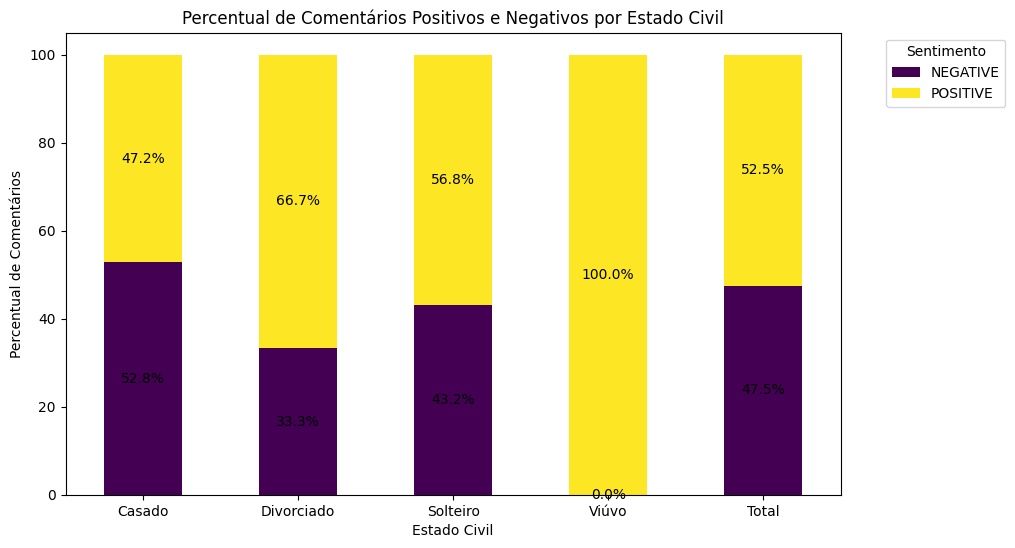

In [19]:
# Grafico de percentual de sentimentos por Estado Civil

bar_plot('flair_sentiment_analysis', 'Estado Civil', df)

NameError: name 'sns' is not defined

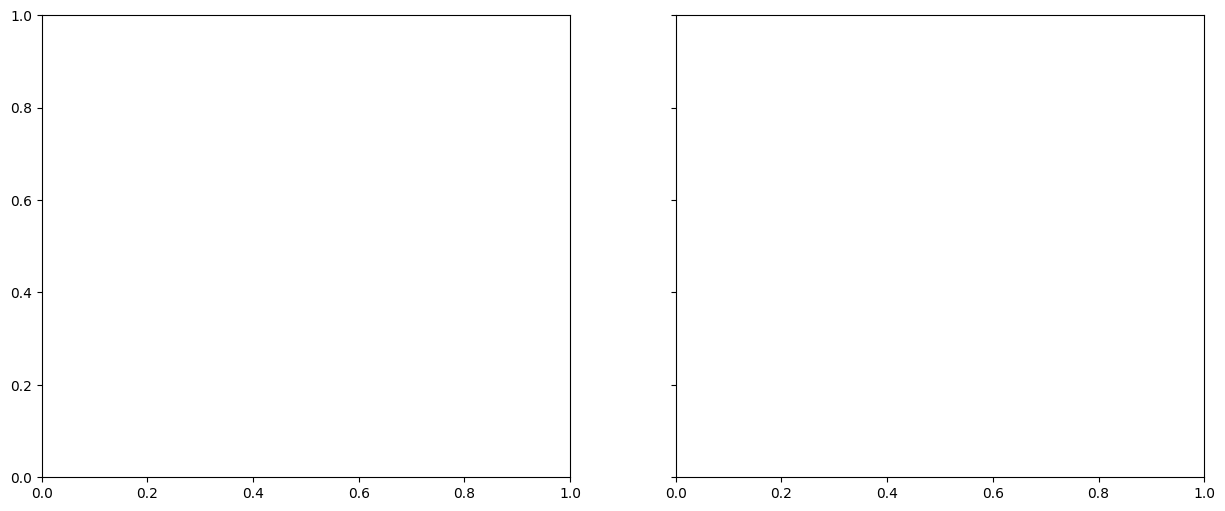

In [21]:
# Grafico boxplot de sentimentos por Valor Mensal do Contrato

boxplot_plot('flair_sentiment_analysis', 'Valor Mensal do Contrato', df)

Os clientes que fizeram comentários positivos são pagantes de valores, em média, maiores que os que fazem comentários negativos. A amplitude dos valores pagos não tem diferenças significativas.

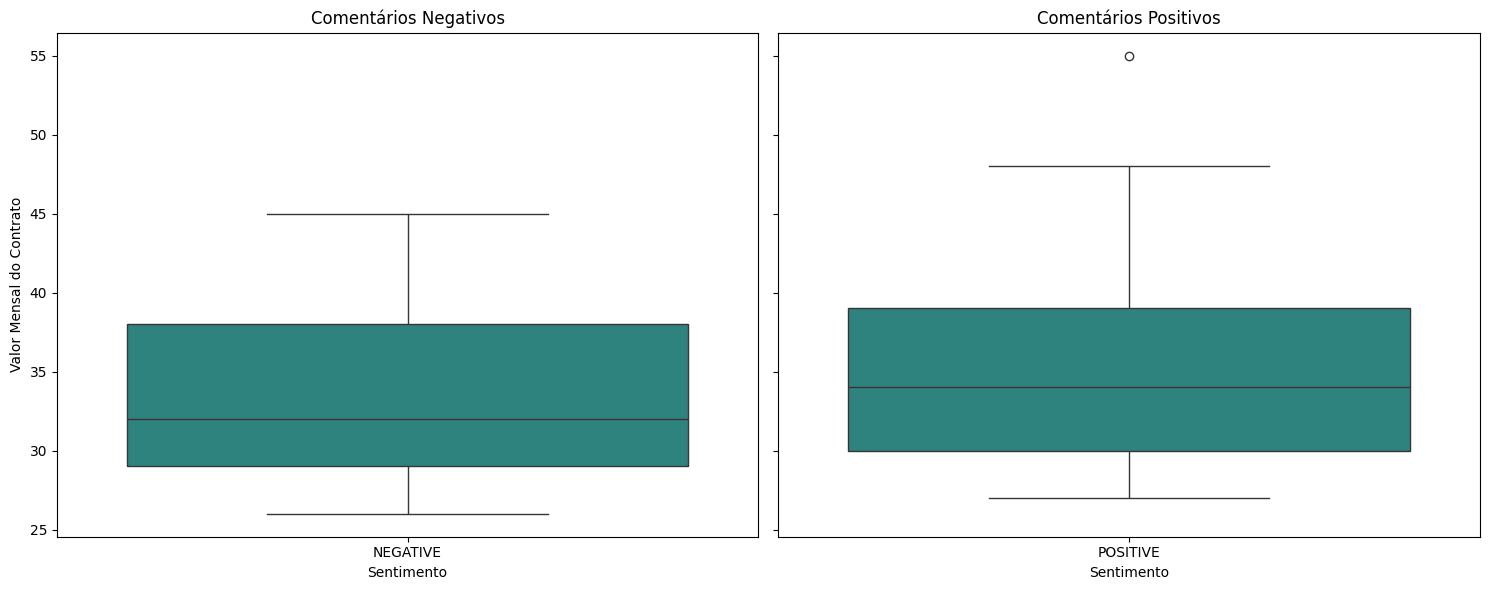

In [ ]:
# Grafico boxplot de sentimentos por Valor Idade

boxplot_plot('flair_sentiment_analysis', 'Idade', df)

Não existem diferencas médias significativas entre as idades dos comentários positivos e negativos. Contudo, a amplitude de idades dos comentários positivos é maior, vindos também de clientes com mais de 45 anos.

__________________________________

#### 2.3 - Processando e analisando o texto dos comentários

In [ ]:
# Instanciando o módulo de pre-processamento de textos e a tabela de stopwords 

nlp = spacy.load('pt_core_news_sm')

nltk.download('stopwords')

stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


A função abaixo realiza o processo de lemmatização no campo de comentários

In [ ]:
# Função para pre-processamento de texto

def preprocess_text(text):
    # Remover pontuações e caracteres especiais
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenização usando spaCy
    tokens = nlp(text)
    
    # Remover stopwords
    tokens = [token.text for token in tokens if token.text.lower() not in stop_words]
    
    # Lematização usando spaCy
    lemmas = [token.lemma_ for token in nlp(" ".join(tokens))]
    
    # Juntar lemas para formar o texto pré-processado
    preprocessed_text = " ".join(lemmas)
    
    return preprocessed_text

# Aplicar a função ao DataFrame
df['lemmatized'] = df['Comentários'].apply(preprocess_text)

# Calculando e registrando o tamanho dos comentários lemmatizados
df['length_lemmatized'] = df['lemmatized'].apply(len)

Análise gráfica da distribuição do tamanho das mensagens e da polaridade

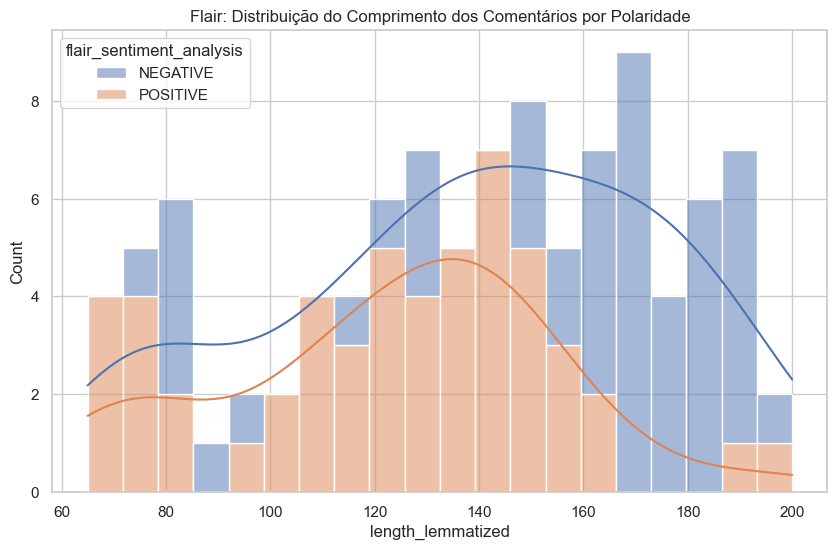

In [ ]:
# Gráfico para a distribuição do comprimento dos comentários e os sentimentos classificados no Flair

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, x='length_lemmatized', hue='flair_sentiment_analysis', multiple="stack", bins=20, kde=True)
ax.set_title('Flair: Distribuição do Comprimento dos Comentários por Polaridade')
plt.show()

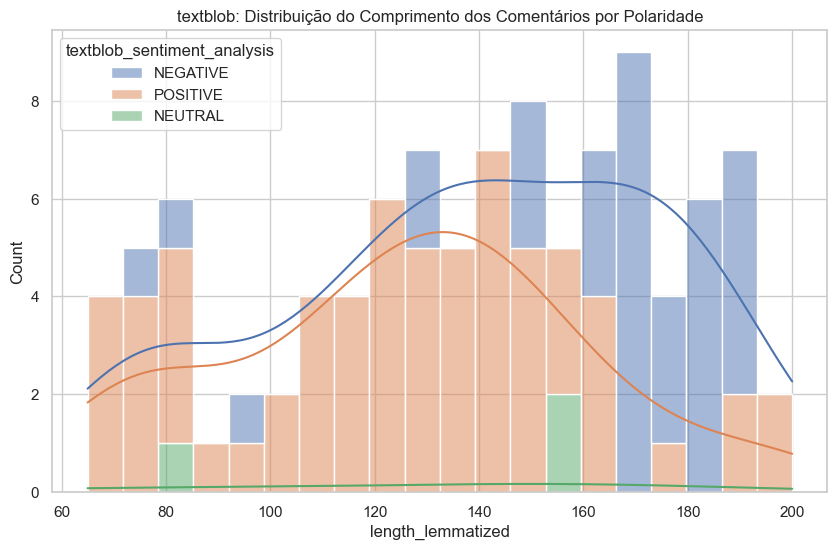

In [ ]:
# Gráfico para a distribuição do comprimento dos comentários e os sentimentos classificados no textblob

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, x='length_lemmatized', hue='textblob_sentiment_analysis', multiple="stack", bins=20, kde=True)
ax.set_title('textblob: Distribuição do Comprimento dos Comentários por Polaridade')
plt.show()

Calcular as frequências em que as palavras surgem nos comentários

In [ ]:
comentarios_concatenados = ' '.join(df['lemmatized'])

# Função para calcular a frequência das palavras usando CountVectorizer e retornar um DataFrame
def calcular_frequencia_total(comentarios):
    # Inicializar o CountVectorizer
    vectorizer = CountVectorizer()

    # Ajustar e transformar os dados
    matriz_contagens = vectorizer.fit_transform([comentarios])

    # Obter os nomes das palavras (features)
    palavras = vectorizer.get_feature_names_out()

    # Obter as contagens de cada palavra
    contagens = matriz_contagens.toarray().flatten()

    # Criar um DataFrame com os dados da análise de frequência
    df_frequencia = pd.DataFrame({'Palavra': palavras, 'Frequencia': contagens})
    
    # Ordenar o DataFrame pela frequência em ordem decrescente
    df_frequencia = df_frequencia.sort_values(by='Frequencia', ascending=False)
    
    return df_frequencia

# Aplicar a função ao DataFrame
resultado_frequencia_total = calcular_frequencia_total(comentarios_concatenados)

In [ ]:
# Visualizando as 25 primeiras palavras mais usadas nos comentários

resultado_frequencia_total[0:24]

,Palavra,Frequencia
219,serviço,72
76,empresa,54
184,problema,48
189,qualidade,43
131,internet,43
232,telefonia,41
57,de,38
227,som,30
241,técnico,29
35,cobertura,29


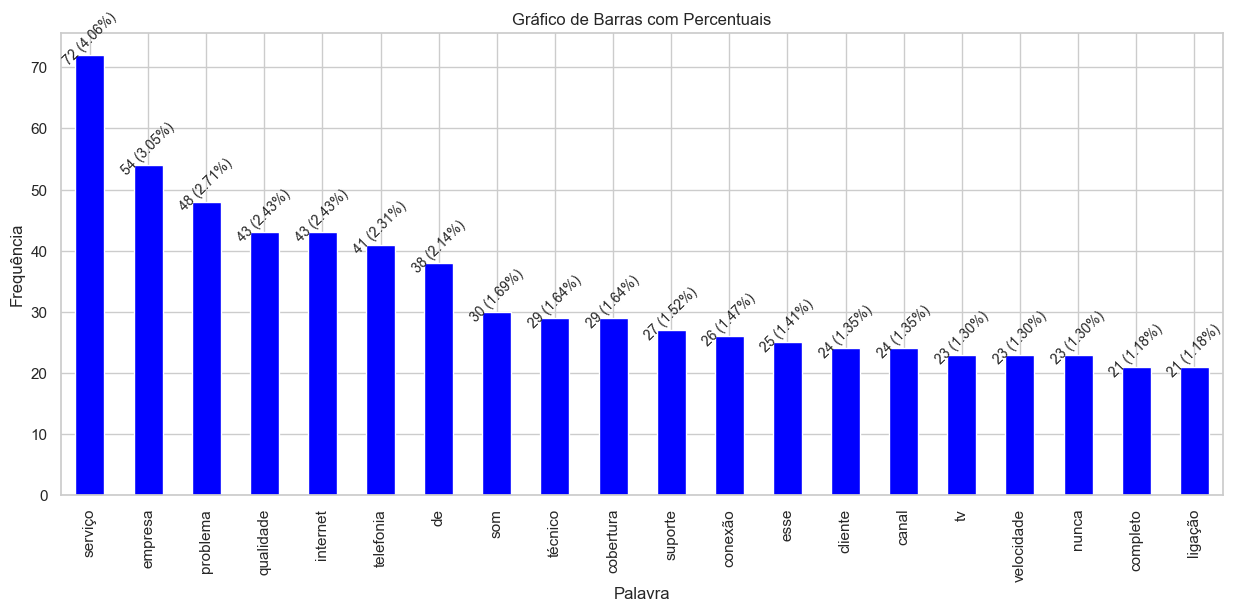

In [ ]:
total_frequencia = resultado_frequencia_total['Frequencia'].sum()

# Calcular os percentuais
resultado_frequencia_total['Percentual'] = (resultado_frequencia_total['Frequencia'] / total_frequencia) * 100

# Criar um gráfico de barras usando pandas
fig, ax = plt.subplots(figsize=(15, 6))  # Defina o tamanho da figura (largura x altura)
resultado_frequencia_total[0:20].plot.bar(x='Palavra', y='Frequencia', color='blue', legend=False, ax=ax)

# Adicionar rótulos percentuais no topo de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f} ({p.get_height() / total_frequencia * 100:.2f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 12),
                textcoords='offset points',fontsize=10, rotation = 45)

# Adicionar rótulos e título
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.title('Gráfico de Barras com Percentuais')

# Exibir o gráfico
plt.show()

Criando uma nuvem de palavras para visualizar as frequências de palavras nos comentários de forma gráfica

In [ ]:
# Customizando stopwords, essas palavras surgiram na análise prévia

stop_words.update(['de', 'esse', 'nunca'])

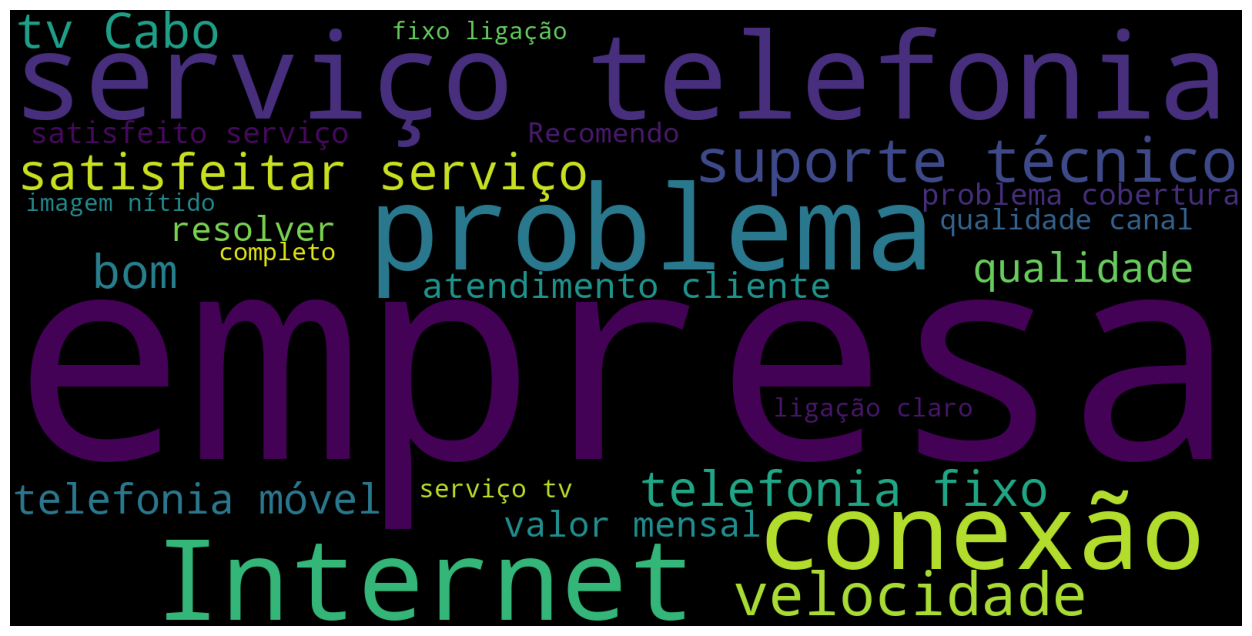

In [ ]:
# Criando o objeto wordcloud com as configs necessárias

wordcloud = WordCloud(stopwords=stop_words,
                      background_color='black', width=1600,
                      height=800, max_words=25, max_font_size=500,
                      min_font_size=1).generate(comentarios_concatenados)

# configurando forma de apresentação do gráfico e apresentando no notebook.

fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

_____________________________________

#### 2.4 Exploração e Análise estatística dos dados

In [ ]:
# Aplicar o mapeamento à coluna 'sentiment_analysis'

df['textblob_numerical'] = df['textblob_sentiment_analysis'].map({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': -1})
df['flair_numerical'] = df['flair_sentiment_analysis'].map({'POSITIVE': 1, 'NEGATIVE': 0})


Aqui é necessário fazer uma ponderação em relação ao churn:
 - O churn foi considerado onde o campo Data de Término do Contrato havia uma data. Por isso apenas 4% da base de dados foi identificada como churn.

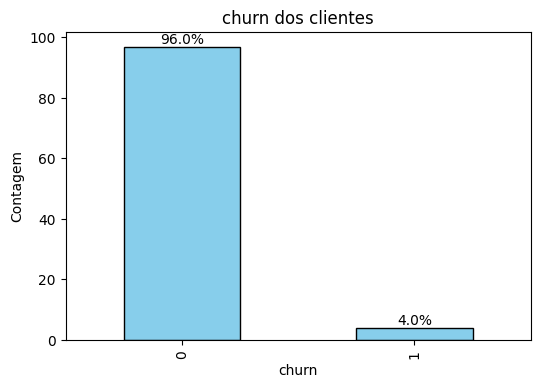

In [ ]:
simple_bar_plot(df, 'churn')


In [ ]:
df[df['churn'] == 1][['flair_sentiment_analysis','textblob_sentiment_analysis']]

,flair_sentiment_analysis,textblob_sentiment_analysis
2,NEGATIVE,NEUTRAL
4,NEGATIVE,NEGATIVE
7,NEGATIVE,POSITIVE
17,POSITIVE,POSITIVE


Como Churn é uma característica que contem apenas 4% dos dados, ela não será considerada para a tomada de decisão em nenhum acionável de negócio, pela ausência de confiança estatística.

In [ ]:
colunas_num = ['Idade','Número de Dependentes','Valor Mensal do Contrato','Duração Média das Chamadas',
               'Volume de Dados','Número de Reclamações','duracao_contrato']
normality_test(df, colunas_num)

,Coluna,p_valor,Normal?
0,Idade,1.150722e-04,False
1,Número de Dependentes,2.378822e-10,False
2,Valor Mensal do Contrato,6.243797e-05,False
3,Duração Média das Chamadas,1.000000e+00,True
4,Volume de Dados,1.000000e+00,True
5,Número de Reclamações,1.000000e+00,True
6,duracao_contrato,1.000000e+00,True


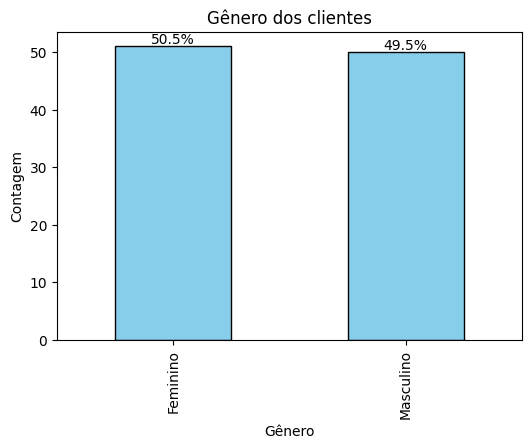

In [ ]:
simple_bar_plot(df, 'Gênero')

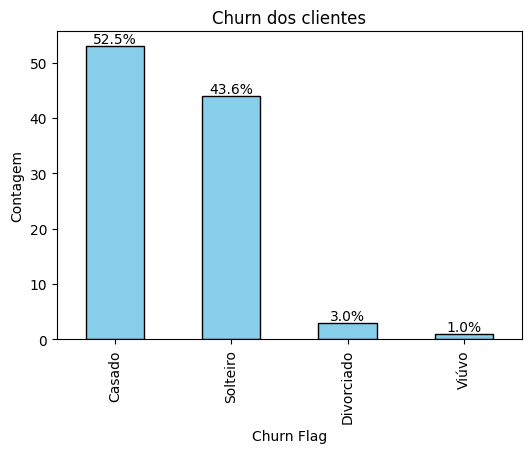

In [ ]:
simple_bar_plot(df, 'Estado Civil')

In [ ]:
df.columns

Index(['Idade', 'Gênero', 'Estado Civil', 'Número de Dependentes',
       'Data de Início do Contrato', 'Data de Término do Contrato',
       'Valor Mensal do Contrato', 'Tipo de Serviço',
       'Duração Média das Chamadas', 'Volume de Dados',
       'Número de Reclamações', 'Comentários', 'churn', 'cidade',
       'estado_sigla', 'duracao_contrato', 'comentarios_eng',
       'flair_sentiment_analysis', 'flair_sentiment_score',
       'textblob_sentiment_polarity', 'textblob_sentiment_analysis',
       'textblob_subjectivity'],
      dtype='object')

In [ ]:
simple_bar_plot(df, 'Estado Civil')

In [ ]:
simple_bar_plot(df, 'Tipo de Serviço')

In [ ]:
simple_bar_plot(df, 'cidade')

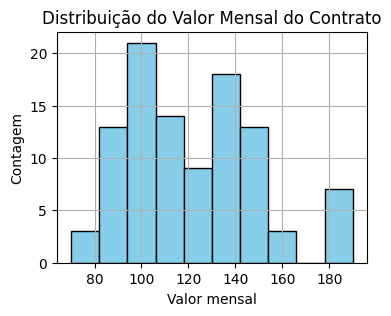

In [ ]:
# Gráfico da distribuição dos scores de seguranca do Flair

plt.figure(figsize=(4, 3))

df['Valor Mensal do Contrato'].hist(bins=10, color='skyblue', edgecolor='black')

plt.title('Distribuição do Valor Mensal do Contrato')
plt.xlabel('Valor mensal')
plt.ylabel('Contagem')

plt.show()

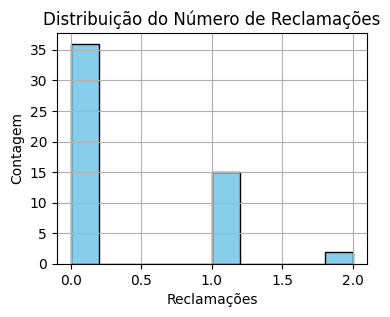

In [ ]:
plt.figure(figsize=(4, 3))

df['Número de Reclamações'].hist(bins=10, color='skyblue', edgecolor='black')

plt.title('Distribuição do Número de Reclamações')
plt.xlabel('Reclamações')
plt.ylabel('Contagem')

plt.show()

CHECAR SE OS SENTIMENTOS POSITIVO/NEGATIVO estão correlacionados com churn, e com as outras variáveis

Alerta: o teste de diferenças tendo como base o churn, embora tenha retornado valores, não pode ser considerado como decisório, uma vez que a diferença de classes de churn é muito grande.

In [ ]:
# Dividir os dados em dois grupos com base na variável 'Churn'

colunas_num = ['Idade','Número de Dependentes','Valor Mensal do Contrato','Duração Média das Chamadas',
               'Volume de Dados','Número de Reclamações','duracao_contrato','textblob_numerical', 'flair_numerical']

churn_grupo_0 = df[df['churn'] == 0][colunas_num].fillna(0)
churn_grupo_1 = df[df['churn'] == 1][colunas_num].fillna(0)

differences_test_num(churn_grupo_0, churn_grupo_1, colunas_num)


,Coluna,p_valor,Diferente?
0,Idade,2.730360e-02,False
1,Número de Dependentes,5.173623e-02,True
2,Valor Mensal do Contrato,3.927984e-01,True
3,Duração Média das Chamadas,5.152399e-02,True
4,Volume de Dados,4.478054e-01,True
5,Número de Reclamações,7.760762e-01,True
6,duracao_contrato,6.181986e-40,False
7,textblob_numerical,9.196103e-01,True
8,flair_numerical,2.659970e-01,True


In [ ]:
colunas_num = ['Idade','Número de Dependentes','Valor Mensal do Contrato','Duração Média das Chamadas',
               'Volume de Dados','Número de Reclamações','duracao_contrato','churn']

flair_grupo_0 = df[df['flair_numerical'] == 0][colunas_num].fillna(0)
flair_grupo_1 = df[df['flair_numerical'] == 1][colunas_num].fillna(0)

differences_test_num(flair_grupo_0, flair_grupo_1, colunas_num)

,Coluna,p_valor,Diferente?
0,Idade,0.130557,True
1,Número de Dependentes,0.495744,True
2,Valor Mensal do Contrato,0.008476,False
3,Duração Média das Chamadas,0.080556,True
4,Volume de Dados,0.081005,True
5,Número de Reclamações,0.072495,True
6,duracao_contrato,0.534229,True
7,churn,0.265997,True


In [ ]:
categoricas = ['Estado Civil','Tipo de Serviço','Gênero','cidade','estado_sigla','flair_sentiment_analysis','textblob_sentiment_analysis']

differences_test_cat(df, categoricas, 'churn')

,Variavel_Categorica,Estatistica_Chi2,Valor_p,Significativo (0.05)?
0,Estado Civil,32.874279,3.423450e-07,Sim
1,Tipo de Serviço,6.148001,1.046275e-01,Não
2,Gênero,0.000000,1.000000e+00,Não
3,cidade,14.063643,7.094681e-03,Sim
4,estado_sigla,14.063643,7.094681e-03,Sim
5,flair_sentiment_analysis,0.374527,5.405469e-01,Não
6,textblob_sentiment_analysis,7.015271,2.996769e-02,Sim


In [ ]:
categoricas = ['Estado Civil','Tipo de Serviço','Gênero','cidade','estado_sigla','churn']

differences_test_cat(df, categoricas, 'flair_numerical')

,Variavel_Categorica,Estatistica_Chi2,Valor_p,Significativo (0.05)?
0,Estado Civil,2.078897,0.556194,Não
1,Tipo de Serviço,2.142236,0.543415,Não
2,Gênero,0.010933,0.916723,Não
3,cidade,0.921473,0.921460,Não
4,estado_sigla,0.921473,0.921460,Não
5,churn,0.374527,0.540547,Não


____________________________________________

#### Conclusões

Lore ipsu sit

#### Referências

Lore ipsu sit